In [1]:
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(data.table))
suppressPackageStartupMessages(library(gap))
suppressPackageStartupMessages(library(scales))
suppressPackageStartupMessages(library(ggtext)) 
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(dplyr))

Warning message:
“package ‘stringr’ was built under R version 4.3.2”


### 831 individuals with prediabetes at baseline

In [2]:
#reading files
ind_signals_prediabetes <- fread("/ictstr01/groups/itg/teams/zeggini/projects/PLIS/proteomics/phenotype-data/1_prediabetes_pQTLs/significant_independent_SNPs_with_no_header.csv", header = F, sep = ",")
ind_signals_prediabetes$V1 <- gsub("\\.20240911$", "", ind_signals_prediabetes$V1)
ind_signals_prediabetes <- ind_signals_prediabetes %>% select(V1, V5, V6, V7, V9, V12)
ind_signals_prediabetes <- ind_signals_prediabetes %>%
  rename(
    OlinkID = V1,
    chr = V5,
    SNP = V6,
    bp = V7,
    maf = V9,  
    pvalue = V12
  )
TSS <- fread("/ictstr01/groups/itg/teams/zeggini/projects/PLIS/proteomics/cis_and_trans_pQTLs/cis_pQTLs/olink_T1.txt")

In [3]:
head(ind_signals_prediabetes)
ind_signals_prediabetes <- ind_signals_prediabetes[!ind_signals_prediabetes$OlinkID %in% c("OID20816", "OID20775", "OID21485"), ]
dim(subset(ind_signals_prediabetes, ind_signals_prediabetes$maf > 0.05))
ind_signals_prediabetes_1 <- subset(ind_signals_prediabetes, ind_signals_prediabetes$maf > 0.05)

OlinkID,chr,SNP,bp,maf,pvalue
<chr>,<int>,<chr>,<int>,<dbl>,<dbl>
OID20049,2,chr2:145703760,145703760,0.12318800,1.48726e-08
OID20053,1,chr1:210621564,210621564,0.00120773,1.20678e-08
OID20053,2,chr2:222033280,222033280,0.00181159,9.12096e-09
OID20053,3,chr3:53218671,53218671,0.00120773,4.47842e-08
OID20053,3,chr3:167949419,167949419,0.00120773,8.24379e-10
OID20053,6,chr6:73012492,73012492,0.00120773,4.47842e-08


[1] 1172    6

In [4]:
cat("No. of independent signals in the prediabetes group at baseline:", length(ind_signals_prediabetes_1$OlinkID))
cat("\n")

No. of independent signals in the prediabetes group at baseline: 1172


In [5]:
snp_with_gene <- ind_signals_prediabetes_1 %>%
  left_join(TSS, by = "OlinkID") %>%
  mutate(
    cis_trans = case_when(
      chr.x == chr.y & abs(bp - tss_start) <= 1000000 ~ "Cis",
      TRUE ~ "Trans"
    )
  )
snp_with_gene <- snp_with_gene %>% rename(chr_snp = chr.x, chr_gene = chr.y)
#snp_with_gene <- snp_with_gene[complete.cases(snp_with_gene), ]
head(snp_with_gene)
cat("No. of independent Cis-signals in the prediabetes group at baseline:", 
    sum(snp_with_gene$cis_trans == "Cis"), "\n")
cat("\n")
cat("No. of independent Trans-signals in the prediabetes group at baseline:", 
    sum(snp_with_gene$cis_trans == "Trans"), "\n")

cis <- snp_with_gene[snp_with_gene$cis_trans == "Cis"]
trans <- snp_with_gene[snp_with_gene$cis_trans == "Trans"]

cat("\n")
cat("No. of unique plasma proteins with a Cis-independent pQTL:", length(unique(cis$OlinkID)))
cat("\n")
cat("No. of unique plasma proteins with a Trans-independent pQTL:",length(unique(trans$OlinkID)))
cat("\n")
cat("No. of unique plasma proteins with both a Cis and a Trans-independent pQTL:", dim(cis[cis$OlinkID %in% trans$OlinkID]))

snp_with_gene <- snp_with_gene %>%
  mutate(
    chr_gene = ifelse(OlinkID == "OID20461", "X",
               ifelse(OlinkID == "OID21504", "X",
               ifelse(OlinkID == "OID30490", "X",
               ifelse(OlinkID == "OID30572", "X",
               ifelse(OlinkID == "OID30784", "X",
               ifelse(OlinkID == "OID30810", "X",
               ifelse(OlinkID == "OID21302", "X",
               ifelse(OlinkID == "OID21484", "X", chr_gene)))))))),
    
    tss_start = ifelse(OlinkID == "OID20461", 1455509,
                ifelse(OlinkID == "OID21504", 117861535,
                ifelse(OlinkID == "OID30490", 122993574,
                ifelse(OlinkID == "OID30572", 112017731,
                ifelse(OlinkID == "OID30784", 47483612,
                ifelse(OlinkID == "OID30810", 38420623,
                ifelse(OlinkID == "OID21302", 46696375,
                ifelse(OlinkID == "OID21484", 153126969, tss_start))))))))
  )

fwrite(snp_with_gene, "/ictstr01/groups/itg/teams/zeggini/projects/PLIS/proteomics/phenotype-data/1_prediabetes_pQTLs/plots/prediabetes_independent_pQTLs_info.txt")
snp_with_gene1 <- snp_with_gene
# 1. Chromosome lengths including X
chr_lengths <- data.frame(
  chr = c(as.character(1:22), "X"),
  chr_length = c(
    248956422, 242193529, 198295559, 190214555, 181538259, 170805979,
    159345973, 145138636, 138394717, 133797422, 135086622, 133275309,
    114364328, 107043718, 101991189, 90338345, 83257441, 80373285,
    58617616, 64444167, 46709983, 50818468,
    156040895  # X chromosome length
  )
) %>%
  mutate(
    chr_numeric = ifelse(chr == "X", 23, as.numeric(chr))
  ) %>%
  arrange(chr_numeric) %>%
  mutate(
    chr_start = c(0, head(cumsum(chr_length), -1)),
    chr_end = chr_start + chr_length
  )
chr_lengths <- chr_lengths %>%
  mutate(
    chr_numeric = dplyr::case_when(
      chr == "X" ~ 23,
      TRUE ~ as.numeric(chr)
    )
  )

# 2. Ensure chr_snp and chr_gene are characters
snp_with_gene$chr_snp <- as.character(snp_with_gene$chr_snp)
snp_with_gene$chr_gene <- as.character(snp_with_gene$chr_gene)

# 3. Join to get genome-wide start positions
snp_with_gene <- snp_with_gene %>%
  left_join(chr_lengths %>% select(chr, chr_start) %>% rename(chr_snp = chr, chr_start_snp = chr_start), by = "chr_snp") %>%
  left_join(chr_lengths %>% select(chr, chr_start) %>% rename(chr_gene = chr, chr_start_gene = chr_start), by = "chr_gene")

# 4. Calculate genome positions
snp_with_gene <- snp_with_gene %>%
  mutate(
    bp_genome = chr_start_snp + bp,
    tss_genome = chr_start_gene + tss_start
  )

# 5. Bin p-values
snp_with_gene$pvalue_bin <- cut(
  snp_with_gene$pvalue,
  breaks = c(0, 1e-40, 1e-20, 5e-8),
  labels = c("<1e-40", "1e-20 to 1e-40", "5e-8 to 1e-20"),
  include.lowest = TRUE,
  right = FALSE
)

# 6. Midpoints for axis ticks
chr_ticks <- chr_lengths %>%
  mutate(mid = chr_start + chr_length / 2)

OlinkID,chr_snp,SNP,bp,maf,pvalue,chr_gene,tss_start,cis_trans
<chr>,<int>,<chr>,<int>,<dbl>,<dbl>,<int>,<int>,<chr>
OID20049,2,chr2:145703760,145703760,0.123188,1.48726e-08,1,11918988,Trans
OID20065,5,chr5:157302984,157302984,0.171498,4.94874e-08,2,75061108,Trans
OID20067,1,chr1:109817192,109817192,0.225845,6.55588e-12,20,36531506,Trans
OID20072,9,chr9:114960138,114960138,0.483696,7.44880e-09,9,114937688,Cis
OID20073,2,chr2:69948729,69948729,0.272343,3.40735e-08,14,103058998,Trans
OID20075,16,chr16:87926558,87926558,0.268116,7.42750e-42,16,87970122,Cis


No. of independent Cis-signals in the prediabetes group at baseline: 797 

No. of independent Trans-signals in the prediabetes group at baseline: 375 

No. of unique plasma proteins with a Cis-independent pQTL: 704
No. of unique plasma proteins with a Trans-independent pQTL: 324
No. of unique plasma proteins with both a Cis and a Trans-independent pQTL: 121 9

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `chr_numeric = ifelse(chr == "X", 23, as.numeric(chr))`.
Caused by warning in `ifelse()`:
! NAs introduced by coercion”
Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `chr_numeric = dplyr::case_when(chr == "X" ~ 23, TRUE ~
  as.numeric(chr))`.
Caused by warning:
! NAs introduced by coercion”


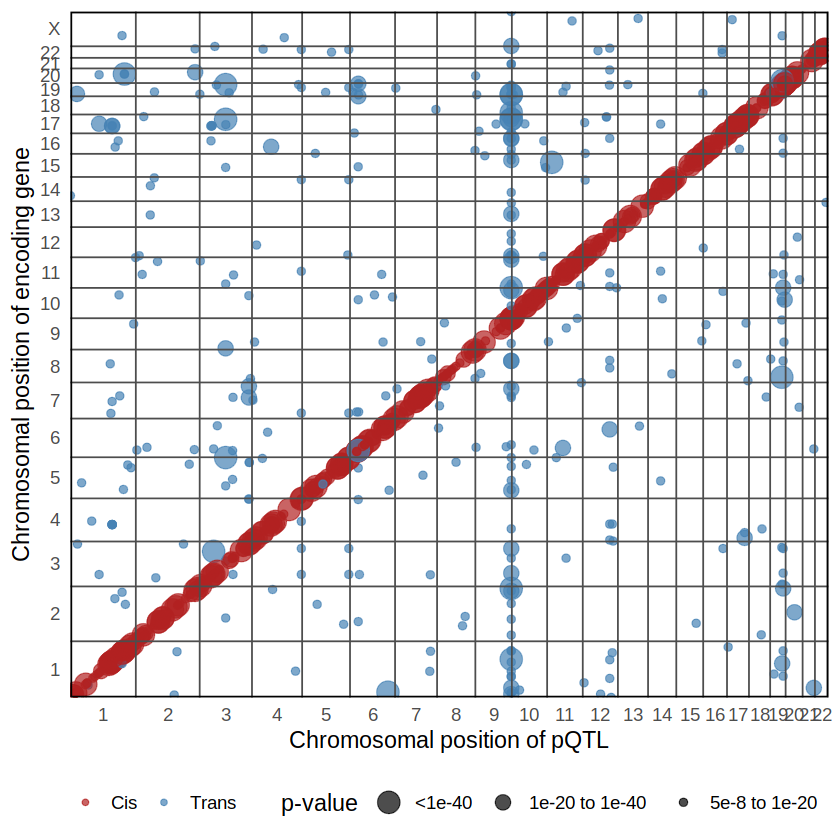

In [16]:
p <- ggplot(snp_with_gene, aes(
  x = bp_genome,
  y = tss_genome,
  color = cis_trans,
  size = pvalue_bin
)) +
  geom_point(alpha = 0.7) +
  
  scale_color_manual(
    values = c("Cis" = "firebrick", "Trans" = "steelblue"),
    name = NULL
  ) +
  
  scale_size_manual(
    values = c("5e-8 to 1e-20" = 2, "1e-20 to 1e-40" = 4, "<1e-40" = 6),
    name = "p-value"
  ) +
  
  guides(
    color = guide_legend(order = 1),
    size = guide_legend(order = 2)
  ) +
  
  scale_x_continuous(
    breaks = chr_ticks$mid,
    labels = chr_ticks$chr,
    name = "Chromosomal position of pQTL",
    expand = c(0, 0)  # <-- remove padding on x-axis edges
  ) +
  
  scale_y_continuous(
    breaks = chr_ticks$mid,
    labels = chr_ticks$chr,
    name = "Chromosomal position of encoding gene",
    expand = c(0, 0)  # <-- remove padding on y-axis edges
  ) +
  
  geom_vline(xintercept = chr_lengths$chr_start[-1], color = "gray30", linetype = "solid") +  
  geom_hline(yintercept = chr_lengths$chr_start[-1], color = "gray30", linetype = "solid") +  
  
  theme_minimal(base_size = 14) +
  theme(
    panel.border = element_rect(color = "black", fill = NA, linewidth = 1),
    panel.grid = element_blank(),
    plot.title = element_text(size = 18, face = "bold"),
    legend.position = "bottom",
    legend.box = "horizontal"
  )

print(p)


### After running the novelty check with Mauro's scripts, this group was found to have 44 novel signals (all in trans)

In [17]:
ggsave("/ictstr01/groups/itg/teams/zeggini/projects/PLIS/proteomics/phenotype-data/1_prediabetes_pQTLs/plots/whole-genome_independent-pQTL.pdf", plot = p, width = 12, height = 7)

### 321 individuals with prediabetes at follow up

In [6]:
#reading files
ind_signals_prediabetes <- fread("/ictstr01/groups/itg/teams/zeggini/projects/PLIS/proteomics/phenotype-data/5_prediabetic_pQTLs/significant_independent_SNPs_with_no_header.csv", header = F, sep = ",")
ind_signals_prediabetes$V1 <- gsub("\\.20240923$", "", ind_signals_prediabetes$V1)
ind_signals_prediabetes <- ind_signals_prediabetes %>% select(V1, V5, V6, V7, V9, V12)
ind_signals_prediabetes <- ind_signals_prediabetes %>%
  rename(
    OlinkID = V1,
    chr = V5,
    SNP = V6,
    bp = V7,
    maf = V9,  
    pvalue = V12
  )
TSS <- fread("/ictstr01/groups/itg/teams/zeggini/projects/PLIS/proteomics/cis_and_trans_pQTLs/cis_pQTLs/olink_T2.txt")

In [7]:
head(ind_signals_prediabetes)
ind_signals_prediabetes <- ind_signals_prediabetes[!ind_signals_prediabetes$OlinkID %in% c("OID20816", "OID20775", "OID21485"), ]
dim(subset(ind_signals_prediabetes, ind_signals_prediabetes$maf > 0.05))
ind_signals_prediabetes <- subset(ind_signals_prediabetes, ind_signals_prediabetes$maf > 0.05)

OlinkID,chr,SNP,bp,maf,pvalue
<chr>,<int>,<chr>,<int>,<dbl>,<dbl>
OID20054,13,chr13:38082720,38082720,0.4265630,4.71811e-08
OID20071,5,chr5:116357982,116357982,0.2640620,1.17807e-08
OID20078,8,chr8:144646665,144646665,0.0062500,1.77691e-09
OID20079,6,chr6:16387426,16387426,0.0093750,1.00445e-08
OID20084,3,chr3:141189842,141189842,0.0046875,3.87121e-08
OID20084,11,chr11:91078387,91078387,0.0046875,4.55025e-08


[1] 555   6

In [8]:
cat("No. of independent signals in the prediabetes group post-intervention:", length(ind_signals_prediabetes$OlinkID))
cat("\n")
head(ind_signals_prediabetes)
head(TSS)

No. of independent signals in the prediabetes group post-intervention: 555


OlinkID,chr,SNP,bp,maf,pvalue
<chr>,<int>,<chr>,<int>,<dbl>,<dbl>
OID20054,13,chr13:38082720,38082720,0.4265630,4.71811e-08
OID20071,5,chr5:116357982,116357982,0.2640620,1.17807e-08
OID20086,22,chr22:19949013,19949013,0.4765620,1.11490e-13
OID20095,7,chr7:124119937,124119937,0.2515630,8.47417e-19
OID20103,1,chr1:170213020,170213020,0.2781250,1.53298e-08
OID20104,14,chr14:74474396,74474396,0.0796875,5.20402e-15


OlinkID,chr,tss_start
<chr>,<int>,<int>
OID20049,1,11918988
OID20050,19,55669141
OID20051,9,86595184
OID20052,20,48807376
OID20053,10,17272003
OID20054,22,29138410


In [9]:
snp_with_gene <- ind_signals_prediabetes %>%
  left_join(TSS, by = "OlinkID") %>%
  mutate(
    cis_trans = case_when(
      chr.x == chr.y & abs(bp - tss_start) <= 1000000 ~ "Cis",
      TRUE ~ "Trans"
    )
  )
snp_with_gene <- snp_with_gene %>% rename(chr_snp = chr.x, chr_gene = chr.y)
#snp_with_gene <- snp_with_gene[complete.cases(snp_with_gene), ]
head(snp_with_gene)
cat("No. of independent Cis-signals in the prediabetes group post-intervention:", 
    sum(snp_with_gene$cis_trans == "Cis"), "\n")
cat("\n")
cat("No. of independent Trans-signals in the prediabetes group post-intervention:", 
    sum(snp_with_gene$cis_trans == "Trans"), "\n")

cis <- snp_with_gene[snp_with_gene$cis_trans == "Cis"]
trans <- snp_with_gene[snp_with_gene$cis_trans == "Trans"]

cat("\n")
cat("No. of unique plasma proteins with a Cis-independent pQTL:", length(unique(cis$OlinkID)))
cat("\n")
cat("No. of unique plasma proteins with a Trans-independent pQTL:",length(unique(trans$OlinkID)))
cat("\n")
cat("No. of unique plasma proteins with both a Cis and a Trans-independent pQTL:", dim(cis[cis$OlinkID %in% trans$OlinkID]))

snp_with_gene <- snp_with_gene %>%
  mutate(
    chr_gene = ifelse(OlinkID == "OID20461", "X",
               ifelse(OlinkID == "OID21484", "X",
               ifelse(OlinkID == "OID30481", "X", chr_gene))),
    
    tss_start = ifelse(OlinkID == "OID20461", 1455509,
                ifelse(OlinkID == "OID21484", 153126969,
                ifelse(OlinkID == "OID30481", 131760044, tss_start)))
  )

fwrite(snp_with_gene, "/ictstr01/groups/itg/teams/zeggini/projects/PLIS/proteomics/phenotype-data/5_prediabetic_pQTLs/plots/prediabetes_independent_pQTLs_info.txt")
snp_with_gene2 <- snp_with_gene
# 1. Chromosome lengths including X
chr_lengths <- data.frame(
  chr = c(as.character(1:22), "X"),
  chr_length = c(
    248956422, 242193529, 198295559, 190214555, 181538259, 170805979,
    159345973, 145138636, 138394717, 133797422, 135086622, 133275309,
    114364328, 107043718, 101991189, 90338345, 83257441, 80373285,
    58617616, 64444167, 46709983, 50818468,
    156040895  # X chromosome length
  )
) %>%
  mutate(
    chr_numeric = ifelse(chr == "X", 23, as.numeric(chr))
  ) %>%
  arrange(chr_numeric) %>%
  mutate(
    chr_start = c(0, head(cumsum(chr_length), -1)),
    chr_end = chr_start + chr_length
  )
chr_lengths <- chr_lengths %>%
  mutate(
    chr_numeric = dplyr::case_when(
      chr == "X" ~ 23,
      TRUE ~ as.numeric(chr)
    )
  )

# 2. Ensure chr_snp and chr_gene are characters
snp_with_gene$chr_snp <- as.character(snp_with_gene$chr_snp)
snp_with_gene$chr_gene <- as.character(snp_with_gene$chr_gene)

# 3. Join to get genome-wide start positions
snp_with_gene <- snp_with_gene %>%
  left_join(chr_lengths %>% select(chr, chr_start) %>% rename(chr_snp = chr, chr_start_snp = chr_start), by = "chr_snp") %>%
  left_join(chr_lengths %>% select(chr, chr_start) %>% rename(chr_gene = chr, chr_start_gene = chr_start), by = "chr_gene")

# 4. Calculate genome positions
snp_with_gene <- snp_with_gene %>%
  mutate(
    bp_genome = chr_start_snp + bp,
    tss_genome = chr_start_gene + tss_start
  )

# 5. Bin p-values
snp_with_gene$pvalue_bin <- cut(
  snp_with_gene$pvalue,
  breaks = c(0, 1e-40, 1e-20, 5e-8),
  labels = c("<1e-40", "1e-20 to 1e-40", "5e-8 to 1e-20"),
  include.lowest = TRUE,
  right = FALSE
)

# 6. Midpoints for axis ticks
chr_ticks <- chr_lengths %>%
  mutate(mid = chr_start + chr_length / 2)

OlinkID,chr_snp,SNP,bp,maf,pvalue,chr_gene,tss_start,cis_trans
<chr>,<int>,<chr>,<int>,<dbl>,<dbl>,<int>,<int>,<chr>
OID20054,13,chr13:38082720,38082720,0.4265630,4.71811e-08,22,29138410,Trans
OID20071,5,chr5:116357982,116357982,0.2640620,1.17807e-08,2,85811531,Trans
OID20086,22,chr22:19949013,19949013,0.4765620,1.11490e-13,22,19929130,Cis
OID20095,7,chr7:124119937,124119937,0.2515630,8.47417e-19,7,124405681,Cis
OID20103,1,chr1:170213020,170213020,0.2781250,1.53298e-08,4,6694796,Trans
OID20104,14,chr14:74474396,74474396,0.0796875,5.20402e-15,14,74486035,Cis


No. of independent Cis-signals in the prediabetes group post-intervention: 398 

No. of independent Trans-signals in the prediabetes group post-intervention: 157 

No. of unique plasma proteins with a Cis-independent pQTL: 398
No. of unique plasma proteins with a Trans-independent pQTL: 148
No. of unique plasma proteins with both a Cis and a Trans-independent pQTL: 18 9

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `chr_numeric = ifelse(chr == "X", 23, as.numeric(chr))`.
Caused by warning in `ifelse()`:
! NAs introduced by coercion”
Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `chr_numeric = dplyr::case_when(chr == "X" ~ 23, TRUE ~
  as.numeric(chr))`.
Caused by warning:
! NAs introduced by coercion”


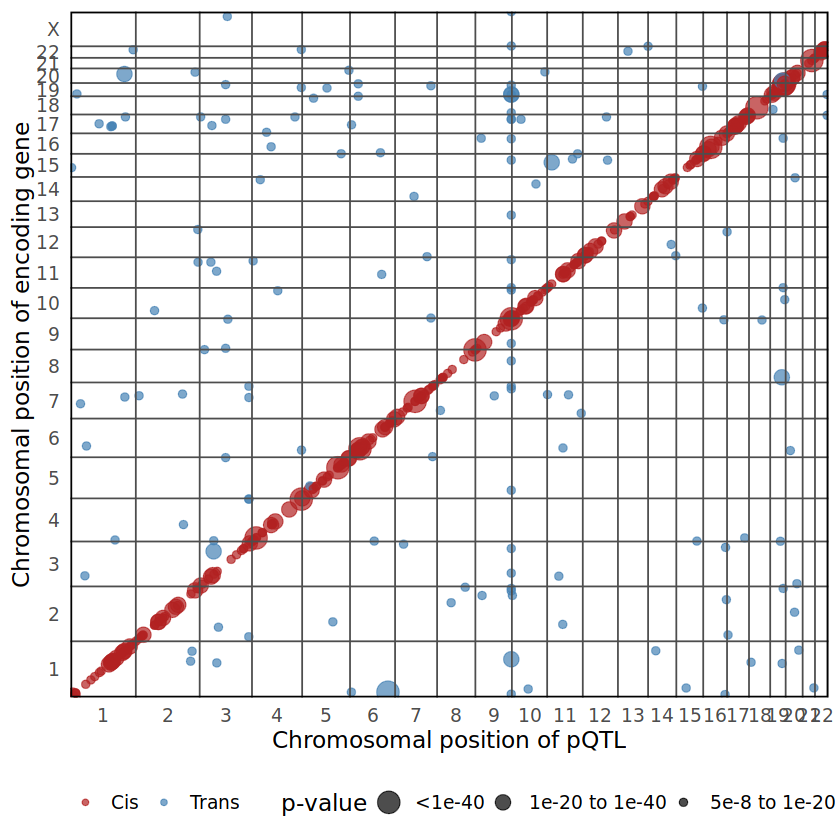

In [33]:
p <- ggplot(snp_with_gene, aes(
  x = bp_genome,
  y = tss_genome,
  color = cis_trans,
  size = pvalue_bin
)) +
  geom_point(alpha = 0.7) +
  
  scale_color_manual(
    values = c("Cis" = "firebrick", "Trans" = "steelblue"),
    name = NULL
  ) +
  
  scale_size_manual(
    values = c("5e-8 to 1e-20" = 2, "1e-20 to 1e-40" = 4, "<1e-40" = 6),
    name = "p-value"
  ) +
  
  guides(
    color = guide_legend(order = 1),
    size = guide_legend(order = 2)
  ) +
  
  scale_x_continuous(
    breaks = chr_ticks$mid,
    labels = chr_ticks$chr,
    name = "Chromosomal position of pQTL",
    expand = c(0, 0)  # <-- remove padding on x-axis edges
  ) +
  
  scale_y_continuous(
    breaks = chr_ticks$mid,
    labels = chr_ticks$chr,
    name = "Chromosomal position of encoding gene",
    expand = c(0, 0)  # <-- remove padding on y-axis edges
  ) +
  
  geom_vline(xintercept = chr_lengths$chr_start[-1], color = "gray30", linetype = "solid") +  
  geom_hline(yintercept = chr_lengths$chr_start[-1], color = "gray30", linetype = "solid") +  
  
  theme_minimal(base_size = 14) +
  theme(
    panel.border = element_rect(color = "black", fill = NA, linewidth = 1),
    panel.grid = element_blank(),
    plot.title = element_text(size = 18, face = "bold"),
    legend.position = "bottom",
    legend.box = "horizontal"
  )

print(p)


In [34]:
ggsave("/ictstr01/groups/itg/teams/zeggini/projects/PLIS/proteomics/phenotype-data/5_prediabetic_pQTLs/plots/whole-genome_independent-pQTL.pdf", plot = p, width = 12, height = 7)

### Identifying if there are any novel pQTLs in the prediabetes group at follow up compared to baseline

In [10]:
# Step 1: keep only proteins present in both datasets
common_proteins <- intersect(snp_with_gene2$OlinkID,
                             snp_with_gene1$OlinkID)

df1 <- snp_with_gene2 %>%
  filter(OlinkID %in% common_proteins)

df2 <- snp_with_gene1 %>%
  filter(OlinkID %in% common_proteins)

# Step 2: join on OlinkID to compare SNPs by protein
all_pairs <- df1 %>%
  inner_join(df2, by = "OlinkID", suffix = c("_df1", "_df2"))

# Step 3: filter for same chromosome and within ±1Mb
matches <- all_pairs %>%
  filter(chr_snp_df1 == chr_snp_df2,
         abs(bp_df1 - bp_df2) <= 1e6)

# Step 4: flag which SNPs in df1 had a match
df1_with_flag <- df1 %>%
  mutate(has_match = SNP %in% matches$SNP_df1)

# Step 5: split into matched and unmatched sets
matched_snps   <- df1_with_flag %>% filter(has_match)
unmatched_snps <- df1_with_flag %>% filter(!has_match)

# -----
# Results:
#   matches        = all matched SNP pairs (df1 ↔ df2)
#   matched_snps   = SNPs from df1 that had at least one match in df2
#   unmatched_snps = SNPs from df1 with no match in df2

Warning message in inner_join(., df2, by = "OlinkID", suffix = c("_df1", "_df2")):
“Detected an unexpected many-to-many relationship between `x` and `y`.
ℹ Row 9 of `x` matches multiple rows in `y`.
ℹ Row 34 of `y` matches multiple rows in `x`.
ℹ If a many-to-many relationship is expected, set `relationship =
  "many-to-many"` to silence this warning.”


In [11]:
unmatched_snps

OlinkID,chr_snp,SNP,bp,maf,pvalue,chr_gene,tss_start,cis_trans,has_match
<chr>,<int>,<chr>,<int>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<lgl>
OID20103,1,chr1:170213020,170213020,0.2781250,1.53298e-08,4,6694796,Trans,FALSE
OID20219,4,chr4:31446345,31446345,0.0623053,4.56838e-08,14,94984181,Trans,FALSE
OID20276,8,chr8:11703657,11703657,0.2616820,1.00684e-09,8,11725738,Cis,FALSE
OID20353,9,chr9:22203800,22203800,0.3283830,3.20019e-08,16,68771128,Trans,FALSE
OID20390,2,chr2:70944349,70944349,0.4236760,4.36987e-09,10,33625190,Trans,FALSE
OID20403,7,chr7:71950266,71950266,0.4672900,2.21562e-08,14,21152336,Trans,FALSE
OID20449,6,chr6:5160059,5160059,0.0514019,1.81268e-08,1,24469611,Trans,FALSE
OID20492,20,chr20:35705609,35705609,0.0747664,3.08216e-08,14,103394982,Trans,FALSE
OID20590,22,chr22:46206700,46206700,0.1900310,2.42766e-08,19,7797057,Trans,FALSE


In [13]:
length(unique(unmatched_snps$OlinkID))

[1] 33

In [14]:
cat("Among the 458 proteins with genome wide significant signal analysed at both timepoints, there are 32 novel trans signals and 2 novel cis signals corresponding to 33 proteins, in the follow up prediabetes group compared to the baseline prediabetes group.")

Among the 458 proteins with genome wide significant signal analysed at both timepoints, there are 32 novel trans signals and 2 novel cis signals corresponding to 33 proteins, in the follow up prediabetes group compared to the baseline prediabetes group.

### Mauro performed a comparison to identify novel pQTLs in our dataset compared to previously published studies
### After running the novelty check with Mauro's scripts, this group was found to have 37 novel signals (all in trans)

#### Now we process the table from that comparison for Supplementary data in the manuscript

In [50]:
follow_up_prediabetes_novelty <- fread("/ictstr01/groups/itg/teams/zeggini/projects/PLIS/proteomics/NoveltyChecks/pQTL_UKBB_Eldjarn_and_Sun_YC_Koprulu.tsv")
follow_up_prediabetes_novelty <- follow_up_prediabetes_novelty[!follow_up_prediabetes_novelty$OlinkID %in% c("OID20816", "OID20775", "OID21485"), ]

In [51]:
follow_up_prediabetes_novelty <- follow_up_prediabetes_novelty %>%
  mutate(Novelty = if_else(is.na(Studies), "Novel", "Known"))
head(follow_up_prediabetes_novelty)

OlinkID,chr_snp,SNP,bp,maf,pvalue,chr_gene,tss_start,cis_trans,UniProt,geneName,bp_38,TSS_38,windowStart,windowEnd,Chr,Studies,Novelty
<chr>,<int>,<chr>,<int>,<dbl>,<dbl>,<chr>,<int>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>
OID20786,1,chr1:962210,962210,0.404984,4.24540e-11,1,955503,Cis,O00468,AGRN,1026830,1020123,26830,2026830,1,UKBB_2023_Sun;Koprulu_2023;UKBB_2023;Zhang_2022;Emilsson_2020,Known
OID21096,1,chr1:9034598,9034598,0.397196,2.34807e-21,1,9005941,Cis,P23280,CA6,8974539,8945882,7974539,9974539,1,UKBB_2023_Sun;Koprulu_2023;UKBB_2023;Emilsson_2020;Suhre_2016;Zhang_2022;Sun_2018;Gudjonsson_2022;Brown_2023;Benson_2018;Carayol_2017;Emilsson_2018;Zhong_2020,Known
OID20274,1,chr1:20306146,20306146,0.232087,1.02032e-13,1,20306107,Cis,P14555,PLA2G2A,19979653,19979614,18979653,20979653,1,UKBB_2023_Sun;Koprulu_2023;UKBB_2023;Emilsson_2020;Yang_2021;Suhre_2016;Zhang_2022;Gudjonsson_2022;Sun_2018;Emilsson_2018;Carayol_2017;Zhong_2021,Known
OID30345,1,chr1:20915701,20915701,0.346395,3.09056e-15,1,20915441,Cis,P32320,CDA,20589208,20588948,19589208,21589208,1,UKBB_2023_Sun;Koprulu_2023;UKBB_2023;Mirauta_2020,Known
OID20578,1,chr1:25583610,25583610,0.400312,1.90866e-12,19,10397680,Trans,Q14773,ICAM4,25257119,10287004,24257119,26257119,1,UKBB_2023_Sun;UKBB_2023;Emilsson_2020;Sun_2018;Gudjonsson_2022,Known
OID21159,1,chr1:109817192,109817192,0.246106,6.21867e-09,17,42422648,Trans,P28799,GRN,109274570,44345280,108274570,110274570,1,UKBB_2023_Sun;UKBB_2023;Yao_2018;Emilsson_2020;Bretherick_2020;Yang_2021;Zhernakova_2018;Brown_2023;Suhre_2016;Sun_2018;Gudjonsson_2022,Known


In [52]:
#adding protein name
prot_ids <- fread("/ictstr01/groups/itg/teams/zeggini/projects/PLIS/proteomics/QC/assay-info.csv", header = T, sep = ",")

follow_up_prediabetes_novelty <- merge(follow_up_prediabetes_novelty, 
                   prot_ids[, c("OlinkID", "Assay")], 
                   by = "OlinkID", 
                   all.x = TRUE)
# Keep only specific columns
df <- follow_up_prediabetes_novelty[, c("Assay", "geneName", "chr_snp", "SNP", "bp", "maf", "pvalue", "chr_gene", "tss_start", "cis_trans", "Novelty")]
head(df)


Assay,geneName,chr_snp,SNP,bp,maf,pvalue,chr_gene,tss_start,cis_trans,Novelty
<chr>,<chr>,<int>,<chr>,<int>,<dbl>,<dbl>,<chr>,<int>,<chr>,<chr>
CHEK2,CHEK2,13,chr13:38082720,38082720,0.4265630,4.71811e-08,22,29138410,Trans,Novel
VAMP5,VAMP5,5,chr5:116357982,116357982,0.2640620,1.17807e-08,2,85811531,Trans,Known
COMT,COMT,22,chr22:19949013,19949013,0.4765620,1.11490e-13,22,19929130,Cis,Known
GPR37,GPR37,7,chr7:124119937,124119937,0.2515630,8.47417e-19,7,124405681,Cis,Known
S100P,S100P,1,chr1:170213020,170213020,0.2781250,1.53298e-08,4,6694796,Trans,Novel
ENTPD5,ENTPD5,14,chr14:74474396,74474396,0.0796875,5.20402e-15,14,74486035,Cis,Known


In [53]:
#getting the ref and alternate allele info
sample <- fread("/ictstr01/groups/itg/teams/zeggini/projects/PLIS/proteomics/phenotype-data/5_prediabetic_pQTLs/PLIS_prediabetic_5/OID21432.20240923/gcta/gcta.mlma.gz", sep = "\t")

In [65]:
# Select only SNP, A1, A2 from sample
sample_subset <- sample[, c("SNP", "A1", "A2")]

# Merge by SNP, keeping all rows from df
merged_df <- merge(df, sample_subset, by = "SNP", all.x = TRUE)
head(merged_df)

SNP,Assay,geneName,chr_snp,bp,maf,pvalue,chr_gene,tss_start,cis_trans,Novelty,A1,A2
<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>
chr10:115488331,CASP7,CASP7,10,115488331,0.2570090,5.20229e-09,10,115439426,Cis,Known,A,G
chr10:11809368,ECHDC3,ECHDC3,10,11809368,0.0846395,2.29288e-13,10,11784365,Cis,Known,T,C
chr10:125248450,PTPN1,PTPN1,10,125248450,0.4112150,2.91913e-08,20,49126891,Trans,Novel,C,T
chr10:125650370,CPXM2,CPXM2,10,125650370,0.4294670,1.75019e-09,10,125651330,Cis,Known,G,A
chr10:131445731,MGMT,MGMT,10,131445731,0.3971960,4.16362e-17,10,131265448,Cis,Known,C,T
chr10:1981965,CASP8,CASP8,10,1981965,0.1043610,2.21421e-08,2,202122759,Trans,Novel,G,T


In [66]:
# Rename columns
setnames(merged_df, old = c("Assay", "bp", "maf", "tss_start", "A1", "A2"),
                     new = c("Protein", "Position", "Effect_allele_frequency", 
                             "Transcription_start_position", "Effect_allele", "Other_allele"))

# Drop geneName column
merged_df[, geneName := NULL]

# Move Protein to first column
new_order <- c("Protein", "SNP", "Effect_allele", "Other_allele",
               setdiff(names(merged_df), c("Protein", "SNP", "Effect_allele", "Other_allele")))
setcolorder(merged_df, new_order)
head(merged_df)

Protein,SNP,Effect_allele,Other_allele,chr_snp,Position,Effect_allele_frequency,pvalue,chr_gene,Transcription_start_position,cis_trans,Novelty
<chr>,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<chr>,<int>,<chr>,<chr>
CASP7,chr10:115488331,A,G,10,115488331,0.2570090,5.20229e-09,10,115439426,Cis,Known
ECHDC3,chr10:11809368,T,C,10,11809368,0.0846395,2.29288e-13,10,11784365,Cis,Known
PTPN1,chr10:125248450,C,T,10,125248450,0.4112150,2.91913e-08,20,49126891,Trans,Novel
CPXM2,chr10:125650370,G,A,10,125650370,0.4294670,1.75019e-09,10,125651330,Cis,Known
MGMT,chr10:131445731,C,T,10,131445731,0.3971960,4.16362e-17,10,131265448,Cis,Known
CASP8,chr10:1981965,G,T,10,1981965,0.1043610,2.21421e-08,2,202122759,Trans,Novel


In [67]:
fwrite(merged_df, "/ictstr01/groups/itg/teams/zeggini/projects/PLIS/proteomics/phenotype-data/5_prediabetic_pQTLs/final_list_ind_pQTLs_all_info.csv", sep = ",")